# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [1]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

Functions from get_files.py imported!


In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37499,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46585,Total threads: 1
Dashboard: /proxy/46095/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39541,


2025-12-02 21:52:23,431 - tornado.application - ERROR - Uncaught exception GET /individual-workers-memory/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='gadi-cpu-bdw-0001.gadi.nci.org.au:43977', method='GET', uri='/individual-workers-memory/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolE

In [3]:
print(client.dashboard_link)

/proxy/8787/status


### Open the intake-esm datastore

In [4]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


NameError: name 'esm_file' is not defined

### What ocean variables are available at monthly frequency?

In [6]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [7]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Load monthly snow thickness (`hs_m`) and plot the field at the last available time

In [8]:
ds = datastore.search(variable=["hs_m", "aice_m"], frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        # chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.rename({
    "geolon": "lon",
    "geolat": "lat"
})
coords = coords.rename_dims({"xh": "ni", "yh": "nj"})
coords = coords.fillna(0.0)
ds = ds.assign_coords(coords)

ds['lon'].attrs['standard_name'] = 'longitude'
ds['lon'].attrs['units'] = 'degrees_east'
ds['lat'].attrs['standard_name'] = 'latitude'
ds['lat'].attrs['units'] = 'degrees_north'
ds = ds.set_coords(['lon', 'lat'])
coords = datastore.search(variable=["TLAT", "TLON"], realm="seaIce", frequency="fx",
                          ).to_dask().compute()
coords = coords.fillna(0.0)
# ds2_cice = xr.merge(ds2_cice, coords)
ds['TLAT'] = coords['TLAT']
ds = ds.set_coords(['TLON', 'TLAT'])
ds

2025-12-02 16:21:00,750 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('_delayed_open_ds-80cbadfa-daae-4154-abc9-4d0b8b08adee')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-12-02 16:21:00,751 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('_delayed_open_ds-905ad19e-6b48-47ce-bce7-6e0703afb3e3')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-12-02 16:21:00,751 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('_delayed_open_ds-99cbb925-519d-447d-96ae-3d6951210b55')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_

### Load CICE6-WIM data

In [5]:
from pathlib import Path
# # /g/data/ia40/cice-dirs/runs/waves-025/
# # /g/data/ps29/nd0349/ia40/waves-025
# # /g/data/ia40/cice-dirs/runs/waves-025/history/MBK_attn
files = sorted(Path("/g/data/ia40/cice-dirs/runs/waves-025/history/MBK_attn").glob("iceh.*.nc"))
ds = xr.open_mfdataset(files[-94], combine='by_coords')
# ds = xr.open_mfdataset(files[-50], combine='by_coords')
ds

<xarray.Dataset> Size: 2GB
Dimensions:        (time: 1, d2: 2, nj: 1080, ni: 1440, nc: 5, nkaer: 5, nf: 12)
Coordinates:
  * time           (time) datetime64[ns] 8B 2019-09-30
    TLON           (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT           (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON           (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT           (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT           (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    NFSD           (nf) float32 48B dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: d2, nj, ni, nc, nkaer, nf
Data variables: (12/107)
    time_bounds    (time, d2) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDa          (nkaer) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    tmask          (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    blkmask        (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    tarea          (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    uarea          (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ...             ...
    dafsd_newi     (time, nf, nj, ni) float32 75MB dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_latg     (time, nf, nj, ni) float32 75MB dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_latm     (time, nf, nj, ni) float32 75MB dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_wave     (time, nf, nj, ni) float32 75MB dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_weld     (time, nf, nj, ni) float32 75MB dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    afsdn          (nc, nf, nj, ni) float32 373MB dask.array<chunksize=(5, 12, 1080, 1440), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 365 days
    comment2:     File written on model date 20190930
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2023-12-20 at 12:13:40.3
    io_flavor:    io_netcdf

In [6]:
ds_plot = ds.where(ds["aice"] > 0.15).isel(nj=slice(0,300))
((ds_plot["hs"] * ds_plot["tarea"]).sum(dim=["ni", "nj"]) / ds_plot["tarea"].sum(dim=["ni", "nj"])).values

array([0.21571484], dtype=float32)

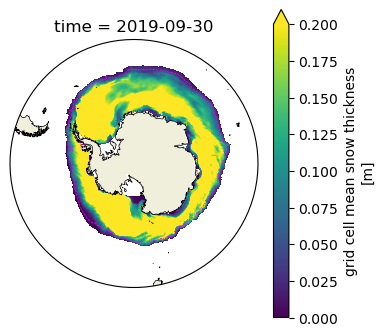

In [7]:
time_idx = -1
hemisphere = "south"
dims = [1, 1]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# ds_plot = ds.isel(nj=slice(0,150))
ds_plot = ds.where(ds["aice"] > 0.15).isel(nj=slice(0,300))
# ds_plot["hs_m"].isel(time=time_idx).plot.pcolormesh(
ds_plot["hs"].isel(time=time_idx).plot.pcolormesh(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    # cmap=cmo.thermal_r,
    vmin=0,
    vmax=0.2,
    x="TLON",
    y="TLAT"
)
# cs = axes[0].contour(ds_plot['TLON'],ds_plot["TLAT"],ds_plot["aice"].isel(time=-1),levels=[0.15, 0.8],transform=ccrs.PlateCarree(),
            # linestyles=["-", "--"],colors="magenta",linewidths=0.5)


transformed_coor=projection.transform_points(ccrs.PlateCarree(),ds_plot['TLON'].values,ds_plot['TLAT'].values)
x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
cs = axes[0].contour(x_ster,y_ster,ds_plot["aice"].isel(time=-1),levels=[0.15],transform=projection,
        linestyles=["-"],colors="magenta",linewidths=0.5)
cs = axes[0].contour(x_ster,y_ster,ds_plot["fsdrad"].isel(time=-1),levels=[200],transform=projection,
        linestyles=["--"],colors="magenta",linewidths=0.5)

# cs = axes[0].contour(x_ster,y_ster,ds_plot["hs"].isel(time=-1),levels=[0.1, 1],transform=projection,
        # linestyles=["--"],colors="blue",linewidths=0.5)

# add_ice_contours(axes[0], ds.isel(time=time_idx), hemisphere, projection)                                   
# ds_hs["aice"].isel(time=time_idx).plot(ax=axes[0],
                                      # transform=ccrs.PlateCarree())

In [8]:
hs_masked = (
    ds_plot["hs"].isel(time=time_idx)
    .where(ds_plot["aice"] > 0.15)
    .where(ds_plot["fsdrad"] < 200)
)

area = ds_plot["tarea"]

# Weighted mean
weighted_mean = (hs_masked * area).sum() / area.where(hs_masked.notnull()).sum()

weighted_mean.values

array(0.0413056, dtype=float32)

Text(0.5, 0.92, '2019-09-30')

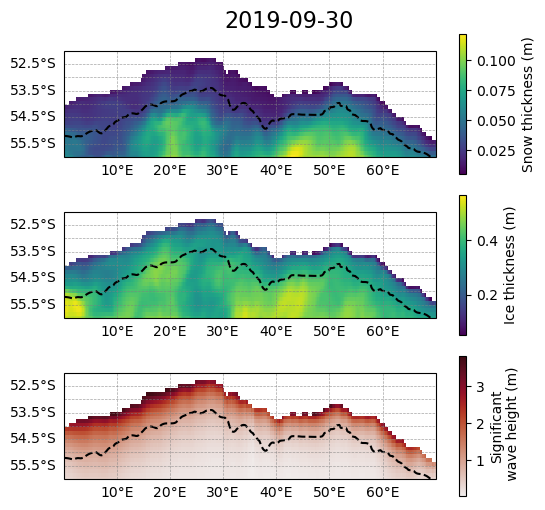

In [9]:
# Weddell Sea approximate bounds
region_extent = [0, 70,   # lon_min, lon_max
                 -56, -52]  # lat_min, lat_max

lon_min, lon_max, lat_min, lat_max = region_extent

ds_region = ds.where(ds.aice > 0.15
).where(
    (ds.TLON >= lon_min) &
    (ds.TLON <= lon_max) &
    (ds.TLAT >= lat_min) &
    (ds.TLAT <= lat_max),
    drop=False,  # keep grid shape but mask values
).isel(time=-1)

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"

# Setup polar projection centered over the Weddell Sea
central_lat = (region_extent[2] + region_extent[3]) / 2
central_lon = (region_extent[0] + region_extent[1]) / 2
# proj = ccrs.Stereographic(central_latitude=central_lat,
                           # central_longitude=central_lon)
proj = ccrs.PlateCarree(#central_latitude=central_lat,
                          # central_longitude=central_lon
)
# proj = ccrs.TransverseMercator(central_longitude=central_lon)
# proj = ccrs.ObliqueMercator(central_longitude=central_lon, central_latitude=central_lat)

dims = [3, 1]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)
fig.set_size_inches(6, 6)   # width, height


# Plot hs over Weddell Sea
pcm0 = ds_region["hs"].plot.pcolormesh(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    # vmax=1.0,
    x="TLON",
    y="TLAT"
)
pcm0.colorbar.set_label("Snow thickness (m)")



pcm1 = ds_region["hi"].plot.pcolormesh(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    # vmax=2,
    # cmap=cmo.matter,
    x="TLON",
    y="TLAT"
)
pcm1.colorbar.set_label("Ice thickness (m)")


pcm = ds_region["wave_sig_ht"].plot.pcolormesh(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    # vmax=3,
    cmap=cmo.amp,
    x="TLON",
    y="TLAT"
)
cbar = pcm.colorbar
cbar.set_label("Significant\n wave height (m)")


for ax in axes:
    transformed_coor=projection.transform_points(
        ccrs.PlateCarree(),
        ds_region['TLON'].values,
        ds_region['TLAT'].values
    )
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    cs = ax.contour(x_ster,y_ster,ds_region["aice"],levels=[0.15],transform=projection,
            linestyles=["-"],colors="magenta",linewidths=1.5)
    cs = ax.contour(x_ster,y_ster,ds_region["fsdrad"],levels=[200],transform=projection,
            linestyles=["--"],colors="k",linewidths=1.5)
    
    # Optionally, set extent to zoom in on
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    ax.set_aspect(5)
    ax.set_title("")
    
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.7,
        linestyle='--'
    )

    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

fig.suptitle('2019-09-30', fontsize=16, y=0.92)

In [10]:
corr = xr.corr(ds_plot["hi"].stack(all_dims=("nj","ni","time")),
                ds_plot["hs"].stack(all_dims=("nj","ni","time")),
                dim="all_dims").values
corr

array(0.8760837, dtype=float32)

In [11]:
### First 100 km from the ice edge

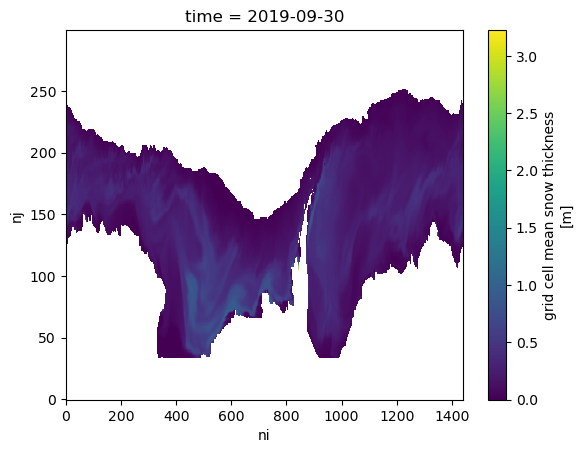

In [12]:
ds_plot["hs"].isel(time=0).plot()

In [13]:
# import xarray as xr
# import numpy as np

# # Select first time step
# aice = ds_plot["aice"].isel(time=0)
# hs = ds_plot["hs"].isel(time=0)
# hte = ds_plot["HTE"]  # grid cell width along nj, same shape as aice or broadcastable

# # Identify ice edge index along nj (first point where aice < 0.15)
# # For each ni (longitude), find the first nj where aice drops below 0.15
# edge_idx = (aice < 0.15).argmax(dim="nj")

# # Compute cumulative distance from ice edge along nj
# # For each ni, subtract edge index and multiply by HTE
# nj_idx = xr.DataArray(np.arange(aice.sizes["nj"]), dims="nj")
# # distance = (nj_idx - edge_idx[:]) * hte[:, nj_idx]  # shape (ni, nj)
# distance = (nj_idx[None, :] - edge_idx[:, None]) * hte  # shape (ni, nj)

# # Mask grid points within ±100 km of ice edge
# mask_100km = np.abs(distance) <= 100

# # Apply mask to hs

In [14]:
import xarray as xr
import numpy as np

# First time step
ds_plot = ds.where(ds["aice"] > 0.15).isel(nj=slice(0,300)).roll(ni=+319, roll_coords=True)

aice = ds_plot["aice"].isel(time=0)
hs = ds_plot["hs"].isel(time=0)
hi = ds_plot["hi"].isel(time=0)
swh = ds_plot["wave_sig_ht"].isel(time=0)
hte = ds_plot["HTE"].isel(time=0)  # shape (ni, nj)
lon = ds_plot["TLON"].isel(nj=100).values

ni, nj = aice.sizes["ni"], aice.sizes["nj"]

# Find ice edge along nj (first aice < 0.15) for each ni
edge_idx = (aice > 0.15).cumsum(dim="nj").argmax(dim="nj")  # shape (ni,)
edge_idx_np = edge_idx.compute().values  # now a NumPy array

ni_idx = np.arange(hte.sizes["ni"])
hte_edge = hte.values[edge_idx_np, ni_idx]
hs_edge = hs.values[edge_idx_np, ni_idx]

dist_range = range(10)
dist_from_edge = np.zeros((len(dist_range), ni))
hs_from_edge = np.zeros((len(dist_range), ni))
hi_from_edge = np.zeros((len(dist_range), ni))
swh_from_edge = np.zeros((len(dist_range), ni))

for i_edge in dist_range:
    idx = edge_idx_np - i_edge

    # extract hs and hte for this offset
    hs_from_edge[i_edge, :]  = hs.values[idx, ni_idx]
    hi_from_edge[i_edge, :]  = hi.values[idx, ni_idx]
    swh_from_edge[i_edge, :]  = swh.values[idx, ni_idx]
    cell_widths              = hte.values[idx, ni_idx]

    # cumulative distance
    if i_edge == 0:
        dist_from_edge[i_edge, :] = 0  # zero distance at the edge
    else:
        dist_from_edge[i_edge, :] = (
            dist_from_edge[i_edge - 1, :] + cell_widths
        )

dist_from_edge_km = dist_from_edge / 1e3

In [15]:
# ds_plot["TLON"].isel(nj=100).shift(ni=+319).plot()

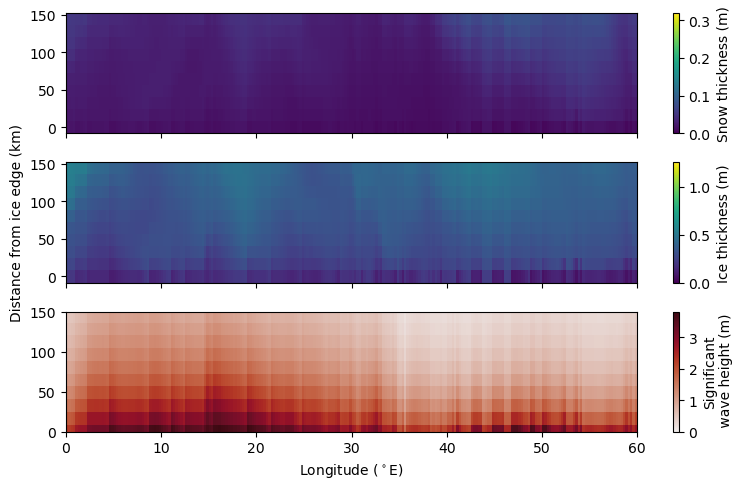

In [16]:
# Make meshgrid for pcolormesh
X, Y = np.meshgrid(lon, dist_from_edge_km[:, 0])

# Create 3×1 figure
fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=True)


# Plot 1
ax = axes[0]   # first axis
pcm = ax.pcolormesh(X, Y, hs_from_edge,
                    shading="auto",
                    cmap='viridis',
)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Snow thickness (m)")
pcm.set_clim(0, np.nanmax(hs_from_edge))   
ax.set_ylabel("")

# Plot 2
ax = axes[1]
pcm = ax.pcolormesh(X, Y, hi_from_edge,
                    shading="auto",
                    cmap='viridis',
)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Ice thickness (m)")
pcm.set_clim(0, np.nanmax(hi_from_edge))   
ax.set_ylabel("Distance from ice edge (km)")

# Plot 3
ax = axes[2]
pcm = ax.pcolormesh(X, Y, swh_from_edge, 
                    shading="auto",
                    cmap=cmo.amp,
)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Significant\n wave height (m)")
pcm.set_clim(0, np.nanmax(swh_from_edge))   
ax.set_ylabel("")


ax.set_xlabel("Longitude ($^\circ$E)")

plt.xlim((0,60))
plt.ylim((0,150))
# Optional: show plot
plt.tight_layout()
plt.show()

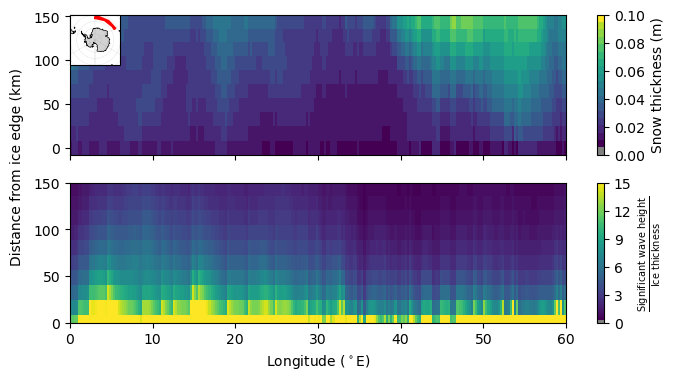

In [17]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import NullLocator
# Make meshgrid for pcolormesh
X, Y = np.meshgrid(lon, dist_from_edge_km[:, 0])

# Create 3×1 figure
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)


# Plot 1
ax = axes[0]   # first axis
levels_fine = np.linspace(0, 0.10, 20) 
levels_ticks = np.linspace(0, 0.10, 6)
viridis = plt.get_cmap('viridis', len(levels_fine)-1)
colors = ['gray'] + [viridis(i) for i in range(viridis.N)]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=levels_fine, ncolors=cmap.N)

pcm = ax.pcolormesh(X, Y, hs_from_edge,
                    shading="auto",
                    cmap=cmap,
                    norm=norm,
)

# Colorbar with coarser ticks
cbar = fig.colorbar(pcm, ax=ax, boundaries=levels_ticks, ticks=levels_ticks, extend='neither')
cbar.ax.yaxis.set_minor_locator(NullLocator())
cbar.set_label("Snow thickness (m)")
pcm.set_clim(0, 0.10)   
ax.set_ylabel("")




# Plot 2
ax = axes[1]
cmax = 15
levels_fine = np.linspace(0, cmax, 60) 
levels_ticks = np.linspace(0, cmax, 6)
viridis = plt.get_cmap('viridis', len(levels_fine)-1)
colors = ['gray'] + [viridis(i) for i in range(viridis.N)]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=levels_fine, ncolors=cmap.N)

pcm = ax.pcolormesh(X, Y, swh_from_edge/hi_from_edge,
                    shading="auto",
                    cmap=cmap,
                    norm=norm,
)
cbar = fig.colorbar(pcm, ax=ax, boundaries=levels_ticks, ticks=levels_ticks, extend='neither')
cbar.ax.yaxis.set_minor_locator(NullLocator())
cbar.set_label("$\\frac{\\text{Significant wave height}}{\\text{Ice thickness}}$")
pcm.set_clim(0, cmax)   

fig.text(0.05, 0.5, "Distance from ice edge (km)", va='center', rotation='vertical')

ax.set_xlabel("Longitude ($^\circ$E)")

plt.xlim((0,60))
plt.ylim((0,150))

# Optional: show plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax_inset = plt.axes([0.094, 0.755, 0.125, 0.125], projection=ccrs.SouthPolarStereo())
ax_inset.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_inset.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_inset.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
lon_center = lon[len(lon)//2]
lat_center = -65  # example
ax_inset.set_extent([0, 360, -75, -50], crs=ccrs.PlateCarree())
from cartopy import geodesic
# corners of the region
lon_min, lon_max = 0, 60 #lon.min(), lon.max()
lat_min, lat_max = -55, -53  # choose approximate range

ax_inset.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
              [lat_min, lat_min, lat_max, lat_max, lat_min],
              'r-', transform=ccrs.PlateCarree(), linewidth=1.5)

# Now save the figure
fig.savefig("/g/data/ps29/nd0349/access-om3-analysis-figs/snow_ice_inset.png", dpi=300, bbox_inches="tight")
plt.show()

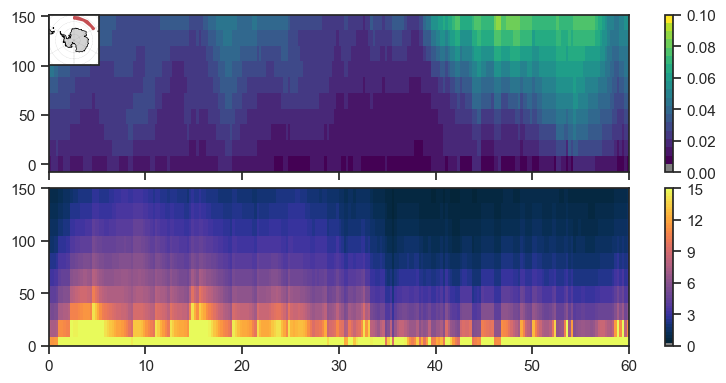

In [39]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import NullLocator

import seaborn as sns
sns.set_theme(style="ticks")
# Make meshgrid for pcolormesh
X, Y = np.meshgrid(lon, dist_from_edge_km[:, 0])

# Create 3×1 figure
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)


# Plot 1
ax = axes[0]   # first axis
levels_fine = np.linspace(0, 0.10, 20) 
levels_ticks = np.linspace(0, 0.10, 6)
viridis = plt.get_cmap('viridis', len(levels_fine)-1)
colors = ['gray'] + [viridis(i) for i in range(viridis.N)]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=levels_fine, ncolors=cmap.N)

pcm = ax.pcolormesh(X, Y, hs_from_edge,
                    shading="auto",
                    cmap=cmap,
                    norm=norm,
)

# Colorbar with coarser ticks
cbar = fig.colorbar(pcm, ax=ax, boundaries=levels_ticks, ticks=levels_ticks, extend='neither')
cbar.ax.yaxis.set_minor_locator(NullLocator())
# cbar.set_label("Snow thickness (m)")
pcm.set_clim(0, 0.10)   
ax.set_ylabel("")




# Plot 2
ax = axes[1]
cmax = 15
levels_fine = np.linspace(0, cmax, 60) 
levels_ticks = np.linspace(0, cmax, 6)
viridis = plt.get_cmap(cmo.thermal, len(levels_fine)-1)
colors = ['gray'] + [viridis(i) for i in range(viridis.N)]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=levels_fine, ncolors=cmap.N)

pcm = ax.pcolormesh(X, Y, swh_from_edge/hi_from_edge,
                    shading="auto",
                    cmap=cmap,
                    norm=norm,
)
cbar = fig.colorbar(pcm, ax=ax, boundaries=levels_ticks, ticks=levels_ticks, extend='neither')
cbar.ax.yaxis.set_minor_locator(NullLocator())
# cbar.set_label("$\\frac{\\text{Significant wave height}}{\\text{Ice thickness}}$")
pcm.set_clim(0, cmax)   

# fig.text(0.05, 0.5, "Distance from ice edge (km)", va='center', rotation='vertical')

# ax.set_xlabel("Longitude ($^\circ$E)")

plt.xlim((0,60))
plt.ylim((0,150))

# Optional: show plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig.tight_layout()

# ax_inset = plt.axes([0.094, 0.755, 0.125, 0.125], projection=ccrs.SouthPolarStereo())
ax_inset = plt.axes([0.04, 0.815, 0.125, 0.125], projection=ccrs.SouthPolarStereo())
ax_inset.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_inset.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_inset.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
lon_center = lon[len(lon)//2]
lat_center = -65  # example
ax_inset.set_extent([0, 360, -75, -50], crs=ccrs.PlateCarree())
from cartopy import geodesic
# corners of the region
lon_min, lon_max = 0, 60 #lon.min(), lon.max()
lat_min, lat_max = -55, -53  # choose approximate range

ax_inset.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
              [lat_min, lat_min, lat_max, lat_max, lat_min],
              'r-', transform=ccrs.PlateCarree(), linewidth=1.5)

# Now save the figure
fig.subplots_adjust(hspace=0.1)   # try 0.2–0.35
fig.savefig("/g/data/ps29/nd0349/access-om3-analysis-figs/snow_ice_nolabel.png", dpi=300, bbox_inches="tight")
plt.show()

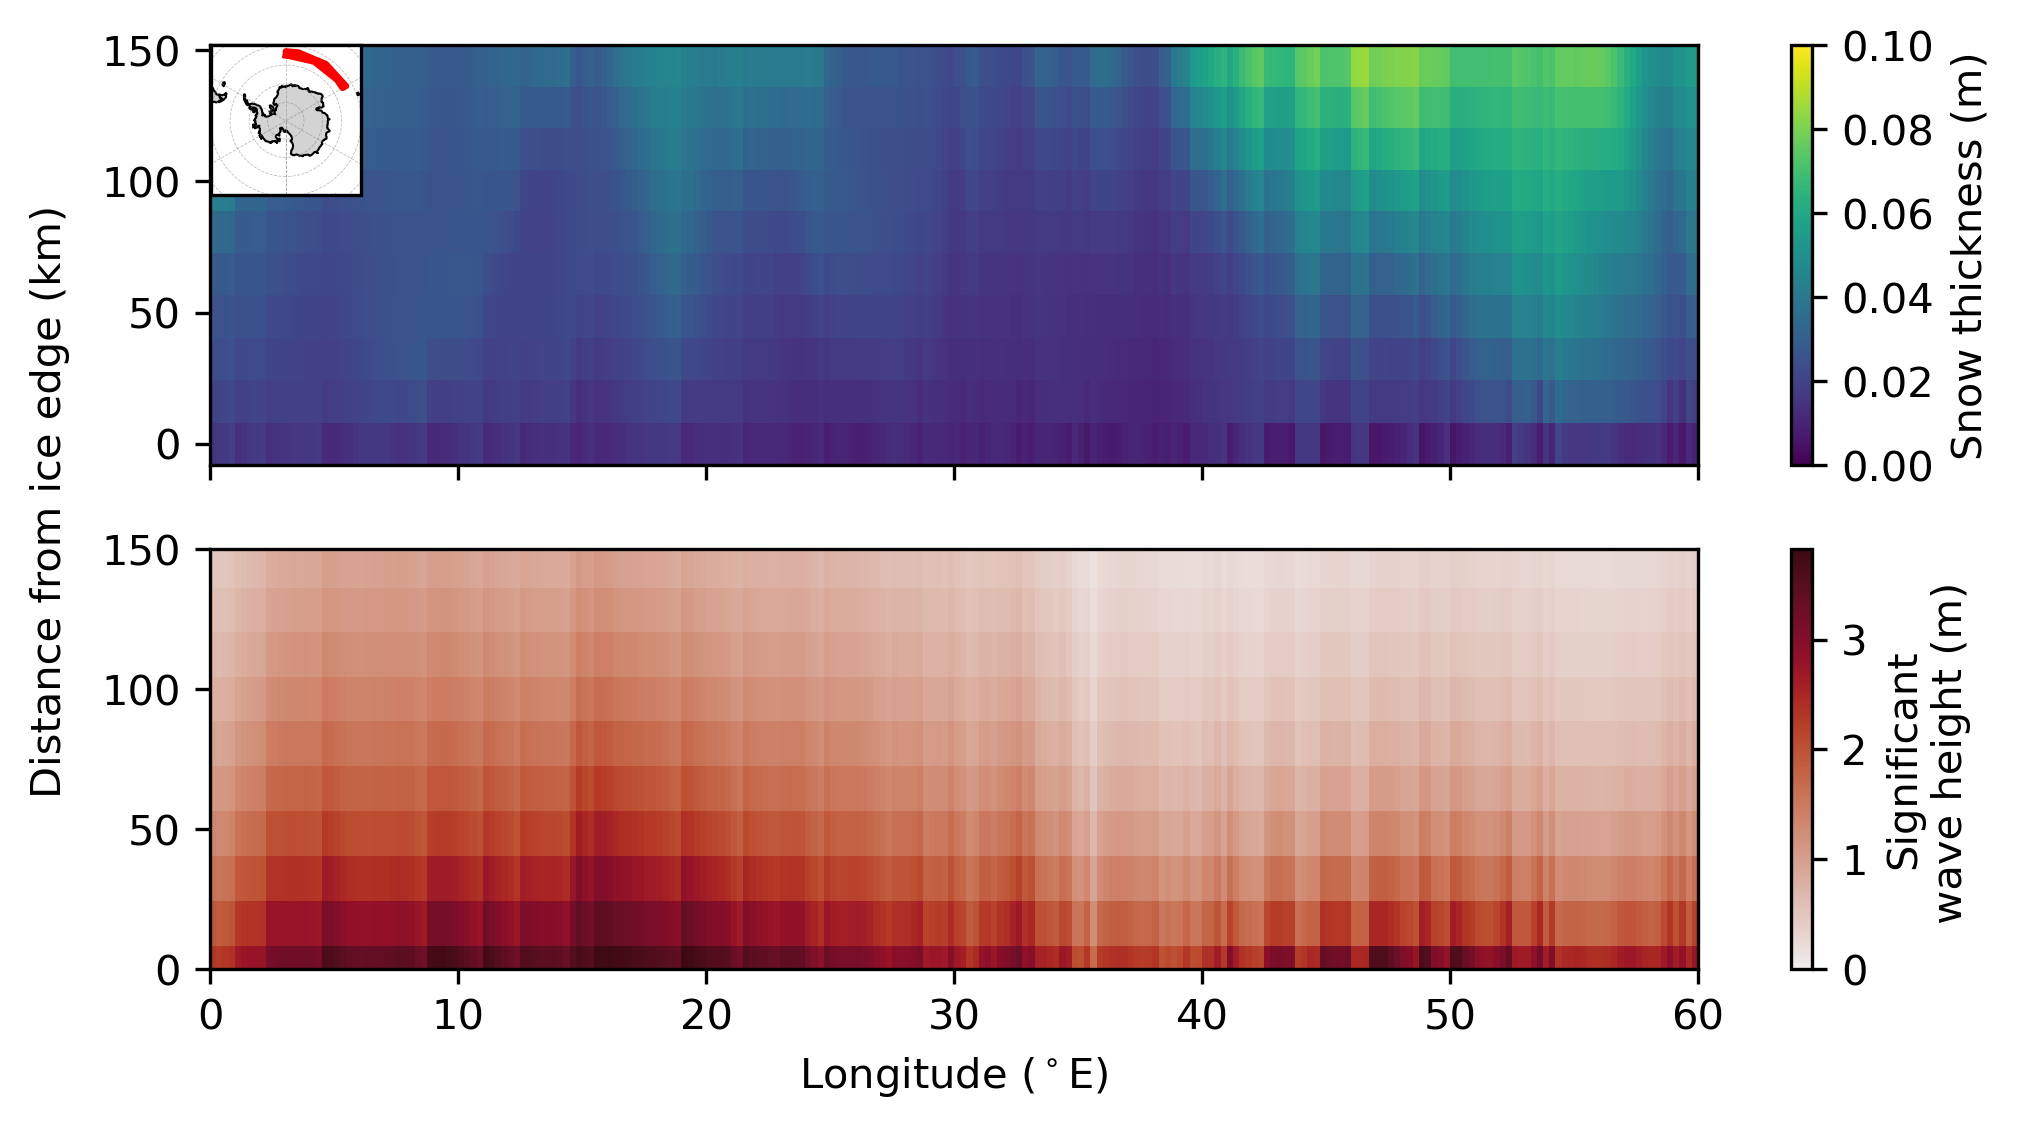

In [94]:
# Make meshgrid for pcolormesh
X, Y = np.meshgrid(lon, dist_from_edge_km[:, 0])

# Create 3×1 figure
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)


# Plot 1
ax = axes[0]   # first axis
pcm = ax.pcolormesh(X, Y, hs_from_edge,
                    shading="auto",
                    cmap='viridis',
)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Snow thickness (m)")
pcm.set_clim(0, 0.10)   
ax.set_ylabel("")

# Plot 2
ax = axes[1]
pcm = ax.pcolormesh(X, Y, swh_from_edge, 
                    shading="auto",
                    cmap=cmo.amp,
)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Significant\n wave height (m)")
pcm.set_clim(0, np.nanmax(swh_from_edge))   
ax.set_ylabel("")


ax.set_xlabel("Longitude ($^\circ$E)")
fig.text(0.05, 0.5, "Distance from ice edge (km)", va='center', rotation='vertical')
plt.xlim((0,60))
plt.ylim((0,150))
# Optional: show plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax_inset = plt.axes([0.094, 0.755, 0.125, 0.125], projection=ccrs.SouthPolarStereo())
ax_inset.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_inset.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_inset.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
lon_center = lon[len(lon)//2]
lat_center = -65  # example
ax_inset.set_extent([0, 360, -75, -50], crs=ccrs.PlateCarree())
from cartopy import geodesic
# corners of the region
lon_min, lon_max = 0, 60 #lon.min(), lon.max()
lat_min, lat_max = -55, -53  # choose approximate range

ax_inset.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
              [lat_min, lat_min, lat_max, lat_max, lat_min],
              'r-', transform=ccrs.PlateCarree(), linewidth=1.5)
fig.savefig("/g/data/ps29/nd0349/access-om3-analysis-figs/snow_swh.png", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # --------------------------
# # Create 4×1 figure
# # --------------------------
# fig = plt.subplots(4, 1, figsize=(8, 10),
#                    gridspec_kw={"height_ratios":[1,1,1,1.4]})[0]
# ax1 = plt.subplot(4,1,1)
# ax2 = plt.subplot(4,1,2)
# ax3 = plt.subplot(4,1,3)
# ax4 = plt.subplot(4,1,4, projection=ccrs.SouthPolarStereo())

# # ============================
# # PANEL 1: Snow thickness
# # ============================
# pcm = ax1.pcolormesh(X, Y, hs_from_edge, shading="auto", cmap="viridis")
# fig.colorbar(pcm, ax=ax1).set_label("Snow thickness (m)")
# pcm.set_clim(0, np.nanmax(hs_from_edge))
# ax1.set_ylabel("Distance (km)")
# ax1.set_title("Snow thickness")

# # ============================
# # PANEL 2: Ice thickness
# # ============================
# pcm = ax2.pcolormesh(X, Y, hi_from_edge, shading="auto", cmap="viridis")
# fig.colorbar(pcm, ax=ax2).set_label("Ice thickness (m)")
# pcm.set_clim(0, np.nanmax(hi_from_edge))
# ax2.set_ylabel("Distance (km)")
# ax2.set_title("Ice thickness")

# # ============================
# # PANEL 3: Significant wave height
# # ============================
# pcm = ax3.pcolormesh(X, Y, swh_from_edge, shading="auto", cmap=cmo.amp)
# fig.colorbar(pcm, ax=ax3).set_label("SWH (m)")
# pcm.set_clim(0, np.nanmax(swh_from_edge))
# ax3.set_ylabel("Distance (km)")
# ax3.set_title("Significant wave height")
# ax3.set_xlabel("Longitude (°E)")

# # ============================
# # PANEL 4: Simple lon–lat map
# # ============================
# ax4 = plt.subplot(4,1,4)   # <-- normal Matplotlib axis

# # Extract coastline from TLON/TLAT masking where you have land/ice
# # (antartica_outline is optional — you can use any mask you want)

# landmask = ds_plot["aice"].isel(time=0).values == 0  # ocean=0, land=1 (approx)
# # If you have a land mask variable use that instead!

# # Scatter coastline-like outline
# ax4.scatter(
#     ds_plot["TLON"].values[landmask],
#     ds_plot["TLAT"].values[landmask],
#     s=1, color="black"
# )

# # Plot your sampling longitude line
# ax4.plot(
#     lon,
#     np.ones_like(lon)*(-55),   # reference latitude
#     color="red",
#     lw=1,
#     label="Sampling longitudes"
# )

# ax4.set_xlabel("Longitude (°E)")
# ax4.set_ylabel("Latitude (°S)")
# ax4.set_title("Antarctic map (simple lon–lat)")
# ax4.legend()

# plt.tight_layout()
# plt.show()

In [42]:
(aice < 0.15)

<xarray.DataArray 'aice' (nj: 300, ni: 1440)> Size: 432kB
dask.array<lt, shape=(300, 1440), dtype=bool, chunksize=(300, 1440), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2019-09-30
    TLON     (nj, ni) float32 2MB dask.array<chunksize=(300, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 2MB dask.array<chunksize=(300, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 2MB dask.array<chunksize=(300, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 2MB dask.array<chunksize=(300, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [ ]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()